# Simulations and benchmarks

- Simulation of the real data by CER, VAR and BVAR
- Model-free benchmarks and the dynamic strategy of classical portfolio management

In [1]:
# initialization
import numpy as np
import pandas as pd
import random
import math
import scipy.stats as dist
import tensorflow as tf
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR, DynamicVAR
import statsmodels.api as sm
%matplotlib inline

C:\Users\Laurens\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Import real data 
mdata = pd.read_csv('data.csv') #Three stocks (R,X_s,X_b) Without predictors
data = mdata[['r','xs','xb']]
dates = mdata['Date']
data.index = dates

In [4]:
# Read written away simulated data
# VAR, CER and , BVAR
mdata = pd.read_excel('sim_data_CER.xlsx') #Three stocks (R,X_s,X_b) Without predictors
data = mdata[['r','xs','xb']]
dates = mdata['Date']
data.index = dates


# Constant Expectated Return

$$ y_{t+1} = \mu + \varepsilon_{t+1}, \text{ with }\varepsilon_{t+1} \sim N(0,\sigma^2) $$

not to be confused with Certainty Equivalent Return

In [28]:
# CER (construct model)
T = int(data.shape[0])
n = int(data.shape[1])
mu = np.mean(data,axis=0)
# mu_temp = np.tile(mu.values,(int(data.shape[0]),1))
# sigma = np.std(data-mu_temp)
sigma = np.std(data)

# simulate from the CER
sim = [[0 for x in range(data.shape[1])] for k in range(0,data.shape[0])] 
for k in range(0,data.shape[0]):
    sim[k][0] = mu[0] + np.random.normal(0,sigma[0]**2)
    sim[k][1] = mu[1] + np.random.normal(0,sigma[1]**2)
    sim[k][2] = mu[2] + np.random.normal(0,sigma[2]**2)

tempdata = pd.DataFrame(sim)
tempdata.columns = mdata.columns[1:4]
tempdata.index = dates
data = tempdata
    
# Write away the simulated data in order for it to be reused in each model
# data.to_excel('sim_data_CER.xlsx', sheet_name='sheet1')    

# Vector Autoregressive Model

$$ y_{t+1} = B_0 + B_1 y_t + \varepsilon_{t+1},\text{ with }\varepsilon_{t+1} \sim N(0,\sigma^2) $$

In [74]:
# VAR
dates = mdata['Date']
data = mdata[['r','xs','xb']]
data.index = pd.DatetimeIndex(dates)

model = VAR(data[['r','xs','xb']])
results = model.fit(1)   # fit a VAR(1) model on the data based on only the returns (no predictability)
A = results.coefs

results.summary()

In [ ]:
# Simulate from the VAR model and write away data
sim = [[0 for x in range(mdata.shape[1]-1)] for k in range(0,mdata.shape[0])] 
eps = np.sqrt(np.var(results.resid)).values.reshape(1,3)
x0 = np.random.normal(0,eps[0][0],mdata.shape[0])
x1 = np.random.normal(0,eps[0][1],mdata.shape[0])
x2 = np.random.normal(0,eps[0][2],mdata.shape[0])


for k in range(0,mdata.shape[0]):
    if k == 0:
        Ahat = data[0:1].values.dot(A[0].transpose())
        Ahat = Ahat[0]
    else:
        Ahat = np.array(np.array(sim[k-1]).dot(A[0].transpose()))
    sim[k][0] = Ahat[0] + x0[k]
    sim[k][1] = Ahat[1] + x1[k]
    sim[k][2] = Ahat[2] + x2[k]

tempdata = pd.DataFrame(sim)
tempdata.columns = mdata.columns[1:4]
tempdata.index = dates
data = tempdata

# Write away the simulated data in order for it to be reused in each model
# data.to_excel('sim_data_VAR.xlsx', sheet_name='sheet1')    


## Bayesian-VAR

model: $ y_{t+1} = B_0 + B_1 y_t + \varepsilon_{t+1}, \varepsilon $

The posterior distribution is given in the appendix of the paper of Bart Diris 
With the uniform prior it is as follows:

$$ P(B,\Sigma|Y) \propto |\Sigma|^{-(T+n+1)/2}\exp \left( -\frac{1}{2}[(Y-XB')'(Y-XB')\Sigma^{-1}]  \right) I(B_1) $$

This will be simulated with the help of the Gibbs sampler which on its turn will need the following conditional posteriors:

$$ P(\Sigma,\beta,Y) = \textit{iWishart}\left((Y-XB')'(Y-XB'),T \right), $$
$$ P(\beta,\Sigma,Y) = N_{trunc}\left(\hat{\beta},\Sigma \otimes (X'X)^{-1}\right) $$


In [29]:
# BVAR

# reformatting data
Y = mdata[['r','xs','xb']]
Y = np.asarray(Y) 
Y1 = np.roll(Y,1,axis=0)
Y = np.delete(Y,(0),axis=0)
Y1 = np.delete(Y1,(0),axis=0)
T = Y.shape[0]
n = Y.shape[1]
X = np.column_stack([np.ones(T), Y1])

#The gibbs sampler
def gibbs(X,Y,N=2000,thin=100):
    # initialize variables
    Sigmalist = []
    Blist = []
    Sigma = np.zeros((n,n))
    B = np.zeros((n,n+1))
    
    Y = np.matrix(Y)
    X = np.matrix(X)
    Sigma = np.zeros((n,n))
    B = np.matrix(B)
    
    # Gibbs algorithm
    for i in range(N):
        # To make the series non dependent introduce a thinning
        for j in range(thin):
            # Draw random sample from an inverse Wishart distribution
            Sigma = dist.invwishart.rvs(df=int(T),scale=((Y-X*B.T).T*(Y-X*B.T)))
            # Draw random sample from the truncated multivariate normal distribution
            Bhat = (X.T*X).I*(X.T*Y)
            Btemp = Bhat.reshape((1,-1)).T
            Btemp2 = [int(elem) for elem in Btemp]
            ## TRUNCATED NORMAL (NOT INCLUDED NOW!!!)
            B = np.random.multivariate_normal(Btemp2,np.kron(Sigma,(X.T*X).I)) 
            # reshape in order to remove the vectorization
            B = B.reshape((n,n+1))
            #Only after the burn-in period append the simulated values 
        if (i > 1000):
            Sigmalist.append(Sigma)
            Blist.append(B)
    return Sigmalist,Blist

Sigmalist, Blist = gibbs(X,Y)


In [56]:
# Simulate from the BVAR model and write away data
sim = [[0 for x in range(mdata.shape[1]-1)] for k in range(0,mdata.shape[0])] 

for k in range(0,mdata.shape[0]):
    if k == 0:
        Bhat = data[0:1].values.dot(Blist[0][:,1:4].transpose())
        Bhat = Bhat[0] + Blist[0][:,0]
    else:
        Bhat = np.array(np.array(sim[k-1]).dot(Blist[k][:,1:4].transpose()))
    eps = np.random.multivariate_normal([0,0,0],Sigmalist[k])
    sim[k][0] = Bhat[0] + eps[0]
    sim[k][1] = Bhat[1] + eps[1]
    sim[k][2] = Bhat[2] + eps[2]
    
tempdata = pd.DataFrame(sim)
tempdata.columns = mdata.columns[1:4]
tempdata.index = dates
data = tempdata

# Write away the simulated data in order for it to be reused in each model
# data.to_excel('sim_data_BVAR.xlsx', sheet_name='sheet1')    # already written away :)

# Model free benchmarks
- 1\N weight in each of the stocks
- Full weight in one of the three stocks

1.16819349569
1.04921534055
1.40386946
1.0823582681
0.00443519011176
5.82981011589e-05
0.0157048370371
0.00106715292668


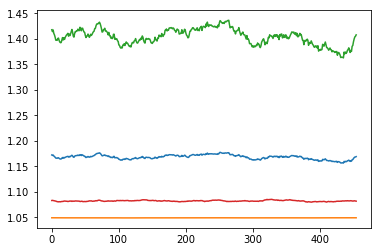

In [17]:
# Model-free benchmarks (1/N or full in the other assets)
# index 239 is the beginning of the out-of-sample analysis 754 (last)
a0 = [1/3,1/3,1/3]
a1 = [1,0,0]
a2 = [0,1,0]
a3 = [0,0,1]

r0list = []
r1list = []
r2list = []
r3list = []

for i in range(240,int(data.shape[0])-60):
    r0 = 0
    r1 = 0
    r2 = 0
    r3 = 0
    for j in range(0,60):
        s1 = data.iloc[i+j,0:4].values.reshape(1,3)
        r0 += sum(a0*s1[0])
        r1 += sum(a1*s1[0])
        r2 += sum(a2*s1[0])
        r3 += sum(a3*s1[0])
    # transform from cumulative log return to Terminal wealth (given starting wealth is normalized to 1)
    r0 = np.exp(r0)
    r1 = np.exp(r1)
    r2 = np.exp(r2)
    r3 = np.exp(r3)
    r0list.append(r0)
    r1list.append(r1)
    r2list.append(r2)
    r3list.append(r3)
    
plt.plot(r0list)
plt.plot(r1list)
plt.plot(r2list)
plt.plot(r3list)

print(np.mean(r0list))
print(np.mean(r1list))
print(np.mean(r2list))
print(np.mean(r3list))

print(np.sqrt(np.var(r0list)))
print(np.sqrt(np.var(r1list)))
print(np.sqrt(np.var(r2list)))
print(np.sqrt(np.var(r3list)))

df = pd.DataFrame({'1/N':r0list, 'full r': r1list, 'full Xs':r2list,'full Xb':r3list, 'Date':mdata['Date'][240:(int(data.shape[0])-60)]})
df.to_excel('Results_MF_Benchmark_CER.xlsx', sheet_name='sheet1')
 

# Dynamic Strategy (Classical portfolio management)

In [ ]:
# Model benchmark (classical portfolio management) 
# expanding window + investment horizon = 5 years (K = 60)

# parsing data
dates = data.index
mdata = data[['r','xs','xb']]
mdata.index = pd.DatetimeIndex(dates)
n = int(data.size/4-4)
periods = 60
simul = 400
beginperiod = 241
gamma = 2 #5 #2 
TW = []
MWeights = []
Index = []
Turnover = []
RU = []
totalRList = []
totalOpimalWeights = []

for i in range(627,700): #   n-periods-1): (possiblity to serialize) (Check 241 )
    # initialization
    optimalweights = np.zeros(periods-1)
    currentK = 0
    rList = []
    print(i)
    
    while currentK < periods-1:
        K = periods - currentK
        
        ## Simulate from the estimate VAR(1) model
        model = VAR(mdata[0:i+currentK]) # take a smaller range to improve speed (like i - 200)
        results = model.fit(1)   # fit a VAR(1) model on the data based on only the returns (no predictability)
        A = results.coefs
        sim = [[[0 for x in range(3)] for k in range(0,K)] for j in range(0,simul)]
        for j in range(0,simul):
            eps = np.sqrt(np.var(results.resid)).values.reshape(1,3)
            x0 = np.random.normal(0,eps[0][0],K)
            x1 = np.random.normal(0,eps[0][1],K)
            x2 = np.random.normal(0,eps[0][2],K)

            for k in range(0,K):
                if k == 0:
                    Ahat = mdata[i:i+1+currentK].values.dot(A[0].transpose())
                    Ahat = Ahat[0]
                else:
                    Ahat = np.array(np.array(sim[j][k-1]).dot(A[0].transpose()))
                sim[j][k][0] = Ahat[0] + x0[k]
                sim[j][k][1] = Ahat[1] + x1[k]
                sim[j][k][2] = Ahat[2] + x2[k]
                
        ## Calculate the optimal weights 
        W = np.linspace(0,1,10)
        Ufut = np.ones(simul)
        OptU = np.ones(simul)*-999
        OptW = np.zeros(simul)
        U = np.zeros(simul)

        for k in range(1,K+1):
            if k < K:
                for w in W:
                    for j in range(0,simul):
                        U[j] = (1/(1-gamma))*(pow((w*np.exp(sim[j][K-k][1]) + (1-w)*np.exp(sim[j][K-k][2])),(1-gamma))*Ufut[j])
                        # Eventually K-k-1 because now i calculate fut Utility of time period T+K+1
                    slice = []
                    for x in range(0,simul):
                        slice.append(sim[x][K-k][1:3])
                    slice = sm.add_constant(slice)
                    olsmodel = sm.OLS(U, slice)
                    CU = olsmodel.fit()
#                     print(CU.params)
                    CU = np.sum(slice * CU.params, axis=1)
                    for j in range(0, simul):
                        if CU[j] > OptU[j]:
                            OptU[j] = CU[j]
                            OptW[j] = w
                slicexs = []
                slicexb = []
                for x in range(0,simul):
                    slicexs.append(sim[x][K-k][1])
                    slicexb.append(sim[x][K-k][2])
                Ufut = (pow(OptW*np.exp(slicexs) + (1-OptW)*np.exp(slicexb),(1-gamma))*Ufut)
#                 print(OptW*np.exp(slicexs))
                OptU = np.ones(simul)*-999
                OptW = np.zeros(simul)
            else:
                for w in W:
                    for j in range(0,simul):
                        U[j] = (1/(1-gamma))*((pow(w*np.exp(sim[j][K-k][1]) + (1-w)*np.exp(sim[j][K-k][2]),(1-gamma)))*Ufut[j])
                    olsmodel = sm.OLS(U, np.ones(simul))
                    CU = olsmodel.fit()
                    CU = np.ones(simul) * CU.params
                    for j in range(0, simul):
                        if CU[j] > OptU[j]:
                            OptU[j] = CU[j]
                            OptW[j] = w
        optimalweights[currentK] = OptW[1]
        rtemp = optimalweights[currentK]*mdata[i+currentK:i+currentK+1]['xs']+(1-optimalweights[currentK])*mdata[i+currentK:i+currentK+1]['xb']
        rList.append(rtemp.values)
        currentK += 1
        
    totalOpimalWeights.append(optimalweights)
    firstdiff = optimalweights[1:] - optimalweights[:-1]
    # Calculate the Terminal Wealth from the given optimalweights  (Check whether indexes are right)
    TerminalWealth = np.exp(sum(optimalweights*mdata[i+1:i+currentK+1]['xs'] + (1-optimalweights)*mdata[i+1:i+currentK+1]['xb']))
    totalRList.append(rList)
    TW.append(TerminalWealth)
    # Mean of the weights
    MWeights.append(np.mean(optimalweights))
    # Index value in time
    Index.append(i)
    # Turnover
    Turnover.append(sum(abs(firstdiff*np.exp(mdata[i+1:i+currentK]['xs'])) + abs((1-firstdiff)*np.exp(mdata[i+1:i+currentK]['xb']))))
    # Realized Utility
    RU.append((1/(1-gamma))*pow(TerminalWealth,(1-gamma)))
    
    print(TerminalWealth)
    print(optimalweights)
    
    print('Writing away results')  # Writes away mostly the same data every time, this is done so the run can be interrupted without losing results
    #     df = pd.DataFrame({'index date':Index,'TW':TW, 'Mean Weights Xs':MWeights})
    df = pd.DataFrame({'index date':Index,'TW':TW, 'Mean Weights Xs':MWeights,'Turnover':Turnover, 'Realized Utility':RU, 'Returns':totalRList, 'Optimal Weights':totalOpimalWeights})
    df.to_excel('REAL_gamma2_ReturnsWeights_627-700.xlsx', sheet_name='sheet1', index=False)


627
1.24575113092
[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.22222222  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]
Writing away results
628
1.32207760766
[ 0.          0.33333333  1.          0.          0.          0.77777778
  0.77777778  0.          0.88888889  0.          0.          0.77777778
  0.          0.66666667  0.11111111  0.22222222  0.          0.44444444
  0.33333333  0.77777778  0.          1.          0.66666667  0.      

639
1.28671140852
[ 0.11111111  0.          0.11111111  0.          0.          0.66666667
  0.          0.11111111  0.77777778  0.11111111  0.          0.          0.
  0.66666667  0.22222222  0.33333333  0.          0.44444444  0.22222222
  1.          0.          0.55555556  0.22222222  0.55555556  1.          1.
  0.66666667  1.          0.11111111  0.66666667  0.          0.44444444
  0.66666667  0.22222222  0.66666667  1.          1.          0.          1.
  0.88888889  1.          0.88888889  1.          1.          0.77777778
  0.88888889  0.66666667  0.44444444  1.          1.          1.          1.
  0.44444444  1.          1.          1.          1.          0.11111111
  0.66666667]
Writing away results
640
1.21213562004
[ 0.          0.44444444  0.          0.          0.          0.          0.
  0.55555556  0.          0.11111111  0.          0.          0.          0.
  0.          0.55555556  0.          0.33333333  0.          0.          0.
  0.          0.         

651
2.22476040548
[ 0.          0.          0.          0.44444444  0.          0.          0.
  0.          0.11111111  0.44444444  0.66666667  0.33333333  0.44444444
  0.77777778  0.55555556  1.          0.44444444  0.88888889  0.22222222
  0.          1.          0.55555556  1.          0.77777778  0.55555556
  1.          1.          0.55555556  1.          1.          0.44444444
  1.          1.          0.          0.77777778  0.66666667  0.33333333
  0.88888889  0.55555556  0.55555556  1.          0.88888889  0.
  0.88888889  1.          0.11111111  0.77777778  0.          0.22222222
  1.          0.55555556  0.88888889  0.55555556  1.          0.44444444
  1.          1.          0.          0.88888889]
Writing away results
652
1.27003399987
[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.     